In [1]:
import os

from PIL import Image
import numpy as np
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q drive/MyDrive/DS_dataset.zip

In [3]:
train_dir = 'train'
test_dir = 'test'

In [4]:
test_paths = []
for label in os.listdir(test_dir):
  label_path = os.path.join(test_dir, label)

  test_images_path = [(label, os.path.join(label_path, image)) for image in os.listdir(label_path)]
  test_paths.extend(test_images_path)

test_df = pd.DataFrame(test_paths, columns = ['label', 'path']).sample(frac = 1.)
len(test_df)

1000

In [5]:
train_images_paths = [(os.path.join(train_dir, file),) for file in os.listdir(train_dir)]
train_df = pd.DataFrame(train_images_paths, columns = ['path']).sample(frac = 1.)
len(train_df)

2669

In [7]:

class DatasetLoader(Dataset):

    def __init__(self, df, anchor_transforms, other_transforms):
        self._df = df
        self._anchor_transforms = anchor_transforms
        self._other_transforms = other_transforms

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):

      row = self._df.iloc[idx]
      base_image_path = row['path']

      while True:

        other_image_path = self._df.sample(1).iloc[0]['path']
        if other_image_path != base_image_path:
          break

      base_image = Image.open(base_image_path).convert('RGB')
      other_image = Image.open(other_image_path).convert('RGB')
      anchor = self._anchor_transforms(base_image)
      negative = self._anchor_transforms(other_image)
      positive = self._other_transforms(base_image)

      return anchor, positive, negative


class TestDatasetLoader(Dataset):

    def __init__(self, df, transforms):
        self._df = df
        self._transforms = transforms


    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):

      row = self._df.iloc[idx]

      base_image_path = row['path']
      label = row['label']


      base_image = Image.open(base_image_path).convert('RGB')
      positive = self._transforms(base_image)

      return positive, label

In [8]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for (_,data, _) in dataloader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches

    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


basic_transformations1 = transforms.Compose([
    transforms.Resize(size=(224,224)),
        transforms.ToTensor()
    ])
temp_dataset = DatasetLoader(train_df, basic_transformations1, basic_transformations1)
temp_dataloader = DataLoader(dataset=temp_dataset, batch_size=64)

means, stds = get_mean_and_std(temp_dataloader)
means, stds

(tensor([0.4609, 0.4236, 0.3002]), tensor([0.2937, 0.2635, 0.2859]))

In [9]:
image_size = 32
crop_size = 32

In [10]:
basic_transformations = transforms.Compose([
    transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
    ])


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(450, 50)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)
        output = output.view(output.shape[0], -1)
        output = self.fc1(output)

        return output

def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)


('ou', torch.Size([2, 50]), torch.Size([2, 3, 32, 32]))


In [18]:

learning_rate = 0.001
model = Network()
model.apply(initialize_weights)
model = model.to(device)

advance_transformions = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.ColorJitter(hue=.5, saturation=.3)], 0.5),

    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=(0, 180))], 0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], 0.4),
    transforms.RandomErasing(p=0.2)

])

basic_transformations = transforms.Compose([
    transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
    ])

dataset = DatasetLoader(train_df, advance_transformions, basic_transformations)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle = True)

loss_func = (
    nn.TripletMarginWithDistanceLoss(
        distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)))

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
device

'cuda'

In [22]:

anchors, positives, negatives  = next(iter(dataloader))


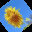

In [23]:
transforms.ToPILImage()(anchors[0])

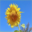

In [24]:
transforms.ToPILImage()(positives[0])

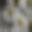

In [25]:
transforms.ToPILImage()(negatives[0])

In [27]:
num_epochs = 100
model.train()

for  epoch in range(num_epochs):
  running_loss = []

  for (anchor_img, positive_img, negative_img) in tqdm(dataloader, desc="Training", leave=False):

    anchor_img = anchor_img.to(device)
    positive_img = positive_img.to(device)
    negative_img = negative_img.to(device)



    anchor_out = model(anchor_img)
    positive_out = model(positive_img)
    negative_out = model(negative_img)

    loss = loss_func(anchor_out, positive_out, negative_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss.append(loss.cpu().detach().numpy())

  print((epoch, np.mean(running_loss)))

In [28]:
test_data_loader = TestDatasetLoader(test_df, basic_transformations)
test_dataloader = DataLoader(dataset=test_data_loader, batch_size=128)
model.eval()
test_res = []

with torch.no_grad():

  for (images, labels) in tqdm(test_dataloader, desc="test", leave=False):
    images = images.to(device)
    images_out = model(images).detach().cpu().numpy()

    for i in range(images_out.shape[0]):
      v = images_out[i]
      l = labels[i]
      test_res.append((v, l))

test_res_df = pd.DataFrame(test_res, columns = ['vector', 'label'])
len(test_res_df)

1000

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans


df_cosine=pd.DataFrame(cosine_similarity(test_res_df['vector'].tolist(),dense_output=True))
df_cosine['label'] = test_res_df['label']
features = df_cosine.drop(columns = ['label'])

kmeans = KMeans(
    init="k-means++",
    n_clusters=5
)

kmeans.fit(features)

clusters = kmeans.predict(features)

test_res_df['cluster'] = clusters

In [29]:
test_res_df.groupby(['label', 'cluster']).size().to_frame('size').reset_index().sort_values(by = ['label', 'cluster'])